# Encoder Decoder

We are training a seperate model for each timestep in the lookahead window

In [1]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
import keras
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matrixprofile as mp
from matplotlib import pyplot as plt

In [2]:
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_start_ix = end_ix + n_step_lookahead -1
        out_end_ix = end_ix + n_steps_out + n_step_lookahead -1
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[out_start_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [3]:
test1 = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\ETH,gas,usage merged 11-26 to 01-26.csv', header=0)

In [4]:
test1.head()

,datetime,gas_limit,gas_used,Open,avg_gas_price,max_gas_price,min_gas_price,block_utilisation
0,2021-11-26 00:00:00,2.999267e+07,1.347163e+07,4524.48,96.879512,340.147750,81.685534,0.449164
1,2021-11-26 00:01:00,2.999999e+07,1.516819e+07,4529.90,100.555432,391.827667,82.407921,0.505607
2,2021-11-26 00:02:00,3.004394e+07,1.820355e+07,4528.51,91.898398,435.102000,75.408292,0.605898
3,2021-11-26 00:03:00,2.999999e+07,1.802044e+07,4533.54,91.047115,378.714800,83.793994,0.600682
4,2021-11-26 00:04:00,3.001463e+07,1.573136e+07,4534.97,108.141500,535.510500,96.352646,0.524123


In [13]:
dict1 = mp.compute(test1['min_gas_price'][:2016].values, windows = 72)

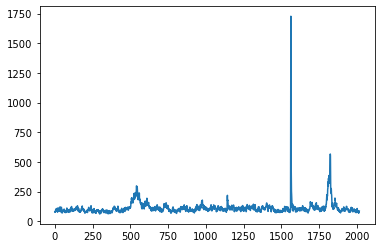

In [15]:
plt.plot(test1['min_gas_price'][:2016])

In [5]:
test1['min_gas_price'][:2016]

0       81.685534
1       82.407921
2       75.408292
3       83.793994
4       96.352646
          ...    
2011    78.787239
2012    69.365984
2013    81.952622
2014    79.127077
2015    86.160574
Name: min_gas_price, Length: 2016, dtype: float64

In [ ]:
#To demonstrate above function
sequence = range(0,13)
n_steps_in = 1
n_steps_in = 5
n_steps_out =1
step_interval =1
n_step_lookahead=5
split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead)

Load data, datetime to index, downsample with left edge label, convert wei to gwei

In [6]:
def generate_training_val_examples():
    #Load data as float, datetime to index
    data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\ETH,gas,usage merged 11-26 to 01-26.csv', header=0)
    data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')
    data = data.set_index('datetime')
    data = data.squeeze()
    data = data.astype('float')

    #Resample with left edge label i.e min 1-5 mean labelled as min1
    data = data.resample(resample_rate).mean()

    #Add 24hr lag for min gas price
    data['min_gas_price_24hr_lag'] = data['min_gas_price'].shift(288)
    data = data[288:]

    #Convert to gwei
    data = data.apply(lambda x: x/1000000000)
    data =data[inputs]

    #Filter inputs
    data =data[inputs]
    scaler = MinMaxScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    y = y[:, :, :1]
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    #we are only lookign to forecast the min gas price
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))
    return X_train, y_train, X_val, y_val



In [10]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2022-01-26 23:55:00' 
inputs = ['min_gas_price', 'max_gas_price', 'min_gas_price_24hr_lag', 'Open']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in =  2016
n_steps_out = 20
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1

In [11]:
X_train, y_train, X_val, y_val = generate_training_val_examples()

In [13]:
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(n_steps_in, len(inputs)), return_sequences=True))
model.add(LSTM(128, activation='tanh', input_shape=(n_steps_in, len(inputs)), return_sequences=True))
model.add(LSTM(128, activation='tanh', input_shape=(n_steps_in, len(inputs)), return_sequences=True))
model.add(LSTM(128, activation='tanh', input_shape=(n_steps_in, len(inputs)), return_sequences=True))
model.add(LSTM(128, activation='tanh', input_shape=(n_steps_in, len(inputs))))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(units=1)))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, verbose=1, batch_size=100, validation_data=(X_val, y_val))


Epoch 1/10
109/109 [==============================] - 91s 678ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 2/10
109/109 [==============================] - 70s 643ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 3/10
109/109 [==============================] - 70s 645ms/step - loss: 9.7838e-04 - val_loss: 0.0017
Epoch 4/10
109/109 [==============================] - 71s 650ms/step - loss: 9.1279e-04 - val_loss: 0.0016
Epoch 5/10
109/109 [==============================] - 70s 645ms/step - loss: 8.9783e-04 - val_loss: 0.0016
Epoch 6/10
109/109 [==============================] - 71s 648ms/step - loss: 8.6649e-04 - val_loss: 0.0016
Epoch 7/10
109/109 [==============================] - 70s 642ms/step - loss: 8.5978e-04 - val_loss: 0.0020
Epoch 8/10
109/109 [==============================] - 70s 645ms/step - loss: 8.5521e-04 - val_loss: 0.0017
Epoch 9/10
109/109 [==============================] - 70s 645ms/step - loss: 8.3249e-04 - val_loss: 0.0016
Epoch 10/10
109/109 [========================

## Evaluation metrics


In [129]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error



In [15]:
yhat = model.predict(X_val, verbose=1)

146/146 [==============================] - 40s 248ms/step


In [137]:
i =3
r2_score(y_val[i], yhat[i])

-0.5628682334342274

In [130]:
def return_metrics(y_val, y_pred):
    RMSE = mean_squared_error(y_val, y_pred, squared=False)
    MAE = mean_absolute_error(y_val, y_pred)
    MAPE = mean_absolute_percentage_error(y_val, y_pred)
    R2 = r2_score(y_val, y_pred)
    MSE = mean_squared_error(y_val, y_pred)
    return RMSE, MAE, MAPE, R2, MSE

In [ ]:
#Define our min max scaler so we can revert transform
#Load data as float, datetime to index
data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\ETH,gas,usage merged 11-26 to 01-26.csv', header=0)
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')
data = data.set_index('datetime')
data = data.squeeze()
data = data.astype('float')

#Resample with left edge label i.e min 1-5 mean labelled as min1
data = data.resample(resample_rate).mean()

#Add 24hr lag for min gas price
data['min_gas_price_24hr_lag'] = data['min_gas_price'].shift(288)
data = data[288:]

#Convert to gwei
data = data.apply(lambda x: x/1000000000)
data =data[inputs]

#Filter inputs
data =data[inputs]
scaler = MinMaxScaler()
data[inputs] = scaler.fit_transform(data[inputs])

In [133]:
RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
for i in range(0, len(y_val)):
    pred_descaled= (scaler.inverse_transform(array([yhat[i],]*(len(inputs))).transpose()[0]))[:, :1]
    val_descaled= (scaler.inverse_transform(array([y_val[i],]*(len(inputs))).transpose()[0]))[:, :1]
    RMSE, MAE, MAPE, R2, MSE = return_metrics((val_descaled*1000000000), (pred_descaled*1000000000))
    RMSE_list.append(RMSE)
    MAE_list.append(MAE)
    MAPE_list.append(MAPE)
    R2_list.append(R2)
    MSE_list.append(MSE)

In [134]:
print('mean_RMSE ' + str(mean(RMSE_list))) 
print('mean_MAE ' + str(mean(MAE_list))) 
print('mean_MAPE ' + str(mean(MAPE_list)))
print('mean_R2 ' + str(mean(R2_list)))



mean_RMSE 41.52602139585727
mean_MAE 32.19459305537631
mean_MAPE 0.21347540999212844
mean_R2 -2.828470045502426
mean_MSE 3207.006911456973


In [104]:
pred_descaled= (scaler.inverse_transform(array([yhat[i],]*(len(inputs))).transpose()[0]))[:, :1]

## We need to define the min max scaler outside of the fucntion so we can revert the transform;

In [77]:
 #Load data as float, datetime to index
data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\ETH,gas,usage merged 11-26 to 01-26.csv', header=0)
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')
data = data.set_index('datetime')
data = data.squeeze()
data = data.astype('float')

#Resample with left edge label i.e min 1-5 mean labelled as min1
data = data.resample(resample_rate).mean()

#Add 24hr lag for min gas price
data['min_gas_price_24hr_lag'] = data['min_gas_price'].shift(288)
data = data[288:]

#Convert to gwei
data = data.apply(lambda x: x/1000000000)
data =data[inputs]

#Filter inputs
data =data[inputs]
scaler = MinMaxScaler()
data[inputs] = scaler.fit_transform(data[inputs])

In [91]:
pred_descaled= (scaler.inverse_transform(array([y_val[500],]*(len(inputs))).transpose()[0]))[:, :1]

In [92]:
pred_descaled

array([[1.11242359e-07],
       [1.18691171e-07],
       [1.33244900e-07],
       [1.26157250e-07],
       [1.24670228e-07],
       [1.13491306e-07],
       [1.32589433e-07],
       [1.02599717e-07],
       [1.21456117e-07],
       [1.49649458e-07],
       [1.74153241e-07],
       [1.16743730e-07],
       [1.46191195e-07],
       [1.22619740e-07],
       [1.27602427e-07],
       [1.30021617e-07],
       [1.32395453e-07],
       [1.26484093e-07],
       [1.19207119e-07],
       [1.24028573e-07]])

In [22]:
#Minmax scaler has been fit with nd data, add dummy columns so the scaler can be applied to min gas rpice
pred_descaled= (scaler.inverse_transform(array([yhat,]*(len(inputs))).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler.inverse_transform(array([y_val,]*(len(inputs))).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(15)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

ValueError: Found array with dim 3. Estimator expected <= 2.

## Lets look at the metrics for all lookaheads

In [29]:
#Create Training Examples for all lookaheads
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2022-01-26 23:55:00' 
inputs = ['min_gas_price', 'max_gas_price', 'min_gas_price_24hr_lag', 'Open']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1

In [30]:
def descale_y_retrun_metrics():
    pred_descaled= (scaler.inverse_transform(array([yhat,]*(len(inputs))).transpose()[0]))[:, :1]
    groud_truth_descaled= (scaler.inverse_transform(array([y_val,]*(len(inputs))).transpose()[0][0]))[ :, :1]
    RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
    MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
    MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
    R2 = r2_score(groud_truth_descaled, pred_descaled)
    return RMSE, MAE, MAPE, R2

In [32]:
RMSE_list, MAE_list, MAPE_list, R2_list = [],[],[],[]
for i in range(1,19):
    n_step_lookahead = i
    model = keras.models.load_model('Direct_Multivariate_Ensemble, n_outputs=1/' + str(i) +'_step_lookahead_Direct_Multivariate' )
    X_train, y_train, X_val, y_val = generate_training_val_examples()
    yhat = model.predict(X_val, verbose=1)
    RMSE, MAE, MAPE, R2 = descale_y_retrun_metrics()
    RMSE_list.append(RMSE)
    MAE_list.append(MAE)
    MAPE_list.append(MAPE)
    R2_list.append(R2)

146/146 [==============================] - 10s 64ms/step


OSError: No file or directory found at Direct_Multivariate_Ensemble, n_outputs=1/10_step_lookahead_Direct_Multivariate

In [33]:
RMSE_list

[4.0278964487451475e-08,
 4.923146750528344e-08,
 5.063530975809405e-08,
 5.199729183768327e-08,
 5.593486080804972e-08,
 5.4786724074945016e-08,
 5.423113120494018e-08,
 5.551279700350256e-08,
 6.222864067640287e-08]

In [34]:
MAPE_list

[0.12471274781395766,
 0.18563279217381598,
 0.18700806022354385,
 0.164386620446668,
 0.22778246758310786,
 0.21044326533314667,
 0.1928804145287867,
 0.19950499581359143,
 0.3041528904611323]